# Cours #1 - Introduction au Machine Learning pour la Classification des Milieux Humides du Lac Ontario

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/geo-stack/cours_ml_envirocan/blob/main/01_dataset_preprocessing.ipynb)

## 1. Configuration de l'environnement

In [25]:
print("Installation de 'gdown' pour le téléchargement du dataset...", end='')
!pip install --upgrade gdown -q
print(' OK')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
import os
import gdown

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

print('Environnement configuré avec succès!')

Installation de 'gdown' pour le téléchargement du dataset... OK
Environnement configuré avec succès!


## 2. Téléchargement et chargement du jeu de données

### 2.1. Téléchargement du jeu de données

> ⚠️ _À noter que l’accès au téléchargement du fichier de données est limité à la période du cours. Passé cette période, le fichier ne sera plus accessible._

In [26]:
INPUT_FILENAME = 'CWRM_GLFEI_vegetation_dataset_v2_extracted_landscape.csv'

print("Téléchargement du jeu de données en cours...")

gdown.download(
    f'https://drive.google.com/uc?id=11oKUaykdZ0G5hpns6nct_lkVvIzo_3w3',
    INPUT_FILENAME,
    quiet=True
    )

print("Téléchargement terminé.")

Téléchargement du jeu de données en cours...
Téléchargement terminé.


### 2.2. Chargement du jeu de données

In [27]:
dtype_spec = {
    'Land_mask': 'boolean',
    'DOMINANCE': 'string',
    }

df = pd.read_csv(INPUT_FILENAME, delimiter=";", dtype=dtype_spec)
df.head()

,SAMPLE_ID,PT_ID,SITE_ID,TILE_ID,LON,LAT,XVAL,YVAL,ZVAL_1m,ZVAL,...,Non-Calcar,Coarse,Fine,Class_Land,Land_mask,HGM_BL,HGM_LOE,HGM_LPP,HGM_RRB,HGM_RRO
0,27552,238582335,5374.0,238,-76.450476,44.276259,384253.723422,4.903583e+06,75.82008,75.541,...,NaN,NaN,NaN,Tree cover,False,False,False,False,False,True
1,32450,238582335,5374.0,238,-76.450476,44.276259,384247.201832,4.903576e+06,75.41211,75.541,...,NaN,NaN,NaN,Tree cover,False,False,False,False,False,True
2,27522,238583332,5374.0,238,-76.450854,44.276344,384216.275492,4.903587e+06,75.04985,74.825,...,NaN,NaN,NaN,Tree cover,False,False,False,False,False,True
3,27523,238583333,5374.0,238,-76.450729,44.276346,384226.649723,4.903587e+06,75.25931,75.029,...,NaN,NaN,NaN,Tree cover,False,False,False,False,False,True
4,27524,238583333,5374.0,238,-76.450729,44.276346,384226.630084,4.903586e+06,75.42680,75.029,...,NaN,NaN,NaN,Tree cover,False,False,False,False,False,True


## 3. Exploration du jeu de données et sélection des variables

Le jeu de données contient des observations de milieux humides du Lac Ontario qui sont directement connectés et influencés par le Lac. Les données proviennent de différentes sources, pour lesquels des variables physiques représentant l'hydro-période, hydrologie, la topographie et le paysage ont été calculées (profondeur, % inondé, période de fluctuation, type de sol, type hydrogéomorphique, pente, etc.). Cette base de données est utilisée pour calibrer un classificateur prédisant une classe de milieu humide à un point donné qui est intégré dans le Coastal Wetland Response Model (CWRM).

<details>
<summary>Tableau 1 : Description des classes de milieu humide à prédire</summary>

<br>

| Acronyme | Description                          |
|----------|--------------------------------------|
| OW       | Open Water                          |
| SAV      | Submerged Aquatic Vegetation        |
| EM       | Emergent marshes                    |
| WM       | Wet Meadow                          |
| SW       | Swamp                               |
| UPL      | Upland                              |

</details>

<br>

<details>
<summary>Tableau 2 : Nom et description des colonnes du jeu de données</summary>
  
<br>

| N° | Colonne                 | Description                                                                                 |
|----|-------------------------|---------------------------------------------------------------------------------------------|
|  1 | SAMPLE_ID               | Identifiant unique de l'échantillon                                                        |
|  2 | PT_ID                   | Identifiant unique du point de grille                                                      |
|  3 | SITE_ID                 | Identiifiant unique du site de milieux humide                                              |
|  4 | TILE_ID                 | Identifiant unique de la tuile du DEM                                                      |
|  5 | LON                     | Coordonnée Longitude (degrés décimaux)                                                     |
|  6 | LAT                     | Coordonnée Latitude (degrés décimaux)                                                      |
|  7 | XVAL                    | Coordonnée Y en UTM (m) (EPSG :32617 ou 32618)                                             |
|  8 | YVAL                    | Coordonnée Y en UTM (m) (EPSG :32617 ou 32618)                                             |
|  9 | ZVAL_1m                 | Coordonnée Z à partir du DEM 1m en IGLD (m) pour quadrats seulement                        |
| 10 | ZVAL                    | Coordonnée Z à partir du DEM 10m en IGLD (m)                                               |
| 11 | YEAR                    | Année d’échantillonnage                                                                    |
| 12 | SOURCE                  | Jeu de données source du relevé                                                            |
| 13 | SOURCE_TYPE             | 'Field Survey' ou 'Photo Interpretation'                                                   |
| 14 | SAV                     | % recouvrement total des espèces de SAV (quadrats seulement)                               |
| 15 | EM                      | % recouvrement total des espèces de EM (quadrats seulement)                                |
| 16 | WM                      | % recouvrement total des espèces de WM (quadrats seulement)                                |
| 17 | SW                      | % recouvrement total des espèces de SW (quadrats seulement)                                |
| 18 | UPL                     | % recouvrement total des espèces de UPL (quadrats seulement)                               |
| 19 | DOMINANCE               | Permet de savoir si le quadrat était mixé ou dominant lors de l’assignation de la classe   |
| 20 | CLASSIF                 | Classe assignée                                                                            |
| 21 | UTM                     | Zone UTM (17 ou 18)                                                                        |
| 22 | SLOPE_10m               | Pente sur résolution spatiale de 10m                                                       |
| 23 | CURVATURE_10m           | Pente seconde sur résolution spatiale de 10m                                               |
| 24 | SLOPE_30m_resampled     | Pente sur résolution spatiale de 30m                                                       |
| 25 | CURVATURE_30m_resampled | Pente seconde sur résolution spatiale de 30m                                               |
| 26 | SLOPE_30m_resampled     | Pente sur résolution spatiale de 30m                                                       |
| 27 | CURVATURE_30m_resampled | Pente seconde sur résolution spatiale de 30m                                               |
| 28 | SLOPE_130m_resampled    | Pente sur résolution spatiale de 130m                                                      |
| 29 | CURVATURE_130m_resampled| Pente seconde sur résolution spatiale de 130m                                              |
| 30 | SLOPE_250m_resampled    | Pente sur résolution spatiale de 250m                                                      |
| 31 | CURVATURE_250m_resampled| Pente seconde sur résolution spatiale de 250m                                              |
| 32 | SLOPE_310m_resampled    | Pente sur résolution spatiale de 310m                                                      |
| 33 | CURVATURE_310m_resampled| Pente seconde sur résolution spatiale de 310m                                              |
| 34 | hMin_SC1                | Profondeur minimale; m.   (année précédente)                                               |
| 35 | hMoy_SC1                | Profondeur moyenne; m.   (année précédente)                                                |
| 36 | hMax_SC1                | Profondeur maximale; m.   (année précédente)                                               |
| 37 | Flood_SC1               | % temps inondé (année précédente)                                                          |
| 38 | PcFMoy_SC1              | % temps strictement inondé; sans fluctuations (année précédente)                          |
| 39 | pcDMoy_SC1              | % temps strictement exondé; sans fluctuations (année précédente)                          |
| 40 | pcFluxMoy_SC1           | % temps fluctuations (année précédente)                                                    |
| 41 | saPxMax_SC1             | Puissance maximale normalisée de l'analyse en ondelettes (année précédente)                |
| 42 | saPMoy_SC1              | Puissance moyenne normalisée de l'analyse en ondelettes (année précédente)                 |
| 43 | TcMin_SC1               | Période minimale des fluctuations (année précédente)                                       |
| 44 | TcMax_SC1               | Période maximale des fluctuations (année précédente)                                       |
| 45 | TcMoy_SC1               | Période moyenne des fluctuations (année précédente)                                        |
| 46 | xTcMax_SC1              | Période maximale détectable des fluctuations (année précédente)                            |
| 47 | hMin_PSC2               | Profondeur minimale; m. (2 ans précédents)                                                |
| 48 | hMoy_PSC2               | Profondeur moyenne; m.  (2 ans précédents)                                                |
| 49 | hMax_PSC2               | Profondeur maximale; m.  (2 ans précédents)                                               |
| 50 | Flood_PSC2              | % temps inondé (2 ans précédents)                                                         |
| 51 | PcFMoy_PSC2             | % temps strictement inondé; sans fluctuations (2 ans précédents)                          |
| 52 | pcDMoy_PSC2             | % temps strictement exondé; sans fluctuations (2 ans précédents)                          |
| 53 | pcFluxMoy_ PSC2         | % temps fluctuations (2 ans précédents)                                                   |
| 54 | saPxMax_ PSC2           | Puissance maximale normalisée de l'analyse en ondelettes (2 ans précédents)               |
| 55 | saPMoy_ PSC2            | Puissance moyenne normalisée de l'analyse en ondelettes (2 ans précédents)                |
| 56 | TcMin_ PSC2             | Période minimale des fluctuations (2 ans précédents)                                      |
| 57 | TcMax_ PSC2             | Période maximale des fluctuations (2 ans précédents)                                      |
| 58 | TcMoy_ PSC2             | Période moyenne des fluctuations (2 ans précédents)                                       |
| 59 | xTcMax_ PSC2            | Période maximale détectable des fluctuations (2 ans précédents)                           |
| 60 | hMin_PSC3               | Profondeur minimale; m. (3 ans précédents)                                                |
| 61 | hMoy_PSC3               | Profondeur moyenne; m.  (3 ans précédents)                                                |
| 62 | hMax_PSC3               | Profondeur maximale; m.  (3 ans précédents)                                               |
| 63 | Flood_PSC3              | % temps inondé (3 ans précédents)                                                         |
| 64 | PcFMoy_PSC3             | % temps strictement inondé; sans fluctuations (3 ans précédents)                          |
| 65 | pcDMoy_PSC3             | % temps strictement exondé; sans fluctuations (3 ans précédents)                          |
| 66 | pcFluxMoy_ PSC3         | % temps fluctuations (3 ans précédents)                                                   |
| 67 | saPxMax_ PSC3           | Puissance maximale normalisée de l'analyse en ondelettes (3 ans précédents)               |
| 68 | saPMoy_ PSC3            | Puissance moyenne normalisée de l'analyse en ondelettes (3 ans précédents)                |
| 69 | TcMin_ PSC3             | Période minimale des fluctuations (3 ans précédents)                                      |
| 70 | TcMax_ PSC3             | Période maximale des fluctuations (3 ans précédents)                                      |
| 71 | TcMoy_ PSC3             | Période moyenne des fluctuations (3 ans précédents)                                       |
| 72 | xTcMax_ PSC3            | Période maximale détectable des fluctuations (3 ans précédents)                           |
| 73 | Organic                 | Type de sol organique (binaire)                                                            |
| 74 | Mineral                 | Type de sol minéral (binaire)                                                              |
| 75 | Rock                    | Type de sol rocheux (binaire)                                                              |
| 76 | Calcareous              | Type de sol calcaire (binaire)                                                             |
| 77 | Non-Calcar              | Type de sol non-calcaire (binaire)                                                         |
| 78 | Coarse                  | Type de substrat grossier (binaire)                                                        |
| 79 | Fine                    | Type de substrat fin (binaire)                                                             |
| 80 | Class_Land              | Classe d'occupation du sol                                                                 |
| 81 | Land_mask               | Si masqué ou non selon la classe d'occupation du sol (boolean)                             |
| 82 | HGM_BL                  | Type hydrogéomorphique : Barrier Lagoon (binaire)                                          |
| 83 | HGM_LOE                 | Type hydrogéomorphique : Baie Ouverte Lacustre (binaire)                                   |
| 84 | HGM_LPP                 | Type hydrogéomorphique : Baie Protégée Lacustre (binaire)                                  |
| 85 | HGM_RRB                 | Type hydrogéomorphique : Embouchure de rivière Barrée (binaire)                            |
| 86 | HGM_RRO                 | Type hydrogéomorphique : Embouchure de rivière Ouverte (binaire)                           |

</details>
<br>

### 3.1. Distribution de la variable cible

L'histogramme révèle un **fort déséquilibre** entre les classes : la classe **UPL** (milieux terrestres) représente 45% du dataset (491k observations), tandis que **OW**, **WM** et **SW** ne comptent que 6% chacune (≈66k observations). Ce déséquilibre nécessite une attention particulière : sans précaution, un modèle pourrait privilégier les classes majoritaires, et une exactitude globale élevée pourrait cacher de mauvaises performances sur les classes minoritaires. Dans les sections suivantes, nous utiliserons systématiquement une **stratification** (`stratify=y`) lors du partitionnement des données pour garantir que chaque ensemble conserve cette distribution.


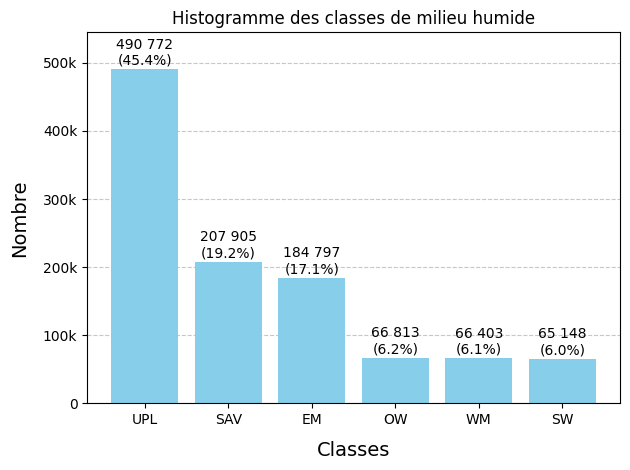

In [28]:
# Génération d'un histogramme du nombre d'observations par classe ('CLASSIF').

counts = df.CLASSIF.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(counts.index, counts.values, color='skyblue')
ax.set_xlabel('Classes', fontsize=14, labelpad=10)
ax.set_ylabel('Nombre', fontsize=14, labelpad=10)
ax.set_title("Histogramme des classes de milieu humide")
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f'{x/1000:0.0f}k' if x >= 1000 else int(x)
        ))

# Ajout padding vertical (10 % au-dessus du max).
ax.set_ylim(top=counts.max() * 1.11)

# Ajout de la valeur et proportion au dessus de chaque barre.
ntot = len(df)
for bar in bars:
    x = bar.get_x() + bar.get_width() / 2
    count = bar.get_height()
    perc = count / ntot * 100
    ax.text(x, count,
            f"{count:,}".replace(",", " ") + "\n" + f"({perc:0.1f}%)",
            ha='center', va='bottom', fontsize=10,
            transform=ax.transData + ScaledTranslation(
                0, 1/72, ax.figure.dpi_scale_trans)
            )

fig.tight_layout()

### 3.2. Sélection des variables explicatives

Dans un premier temps, on retire du jeu de données les variables pouvant biaiser la prédiction (ex: localisation, identifiants).

Ensuite, les modèles sont généralement calibrés en utilisant les variables calculées sur une période donnée (1, 2 ou 3 ans précédents). Les regroupement d'années ne sont pas mélangés. On choisi donc ici une période (1, 2 ou 3 ans) et on ne garde que les variables correspondantes.


In [29]:
# On retire les variables pouvant biaiser la prédiction.
cols_to_drop = [
    'SAMPLE_ID', 'PT_ID', 'SITE_ID', 'TILE_ID', 'LON', 'LAT', 'XVAL',
    'YVAL', 'ZVAL', 'YEAR', 'SOURCE', 'SOURCE_TYPE', 'UTM'
    ]

df_features = df.drop(columns=cols_to_drop)

print(
    f"Les {len(cols_to_drop)} colonnes suivantes ont été retirées du jeu "
    f"de données car elles pourraient potentiellement biaiser le "
    f"modèle de prédiction :\n"
    + "\n".join(f"   - {col}" for col in cols_to_drop)
    )

n_from = df.shape[1]
n_to = df_features.shape[1]
print(f"\nNombre de colonnes : {n_from} → {n_to}")

# On ne garde que les variables calculées sur la période sélectionnée.

selected_period = 1

varnames = ['hMin', 'hMoy', 'hMax', 'Flood', 'pcFMoy', 'pcDMoy', 'pcFluxMoy',
            'saPxMax', 'saPMoy', 'TcMin', 'TcMax', 'TcMoy', 'xTcMax', 'xTqMax']

cols_to_drop = []
for period in [1, 2, 3]:
    if period == selected_period:
        continue

    for varname in varnames:
        colname = (
            varname + (f'_SC{period}' if period == 1 else f'_PSC{period}')
            )
        cols_to_drop.append(colname)

df_features = df_features.drop(columns=cols_to_drop)

print(
    f"\nLes {len(cols_to_drop)} colonnes suivantes ont été retirées du jeu "
    f"de données car elles ne correspondent pas à la période de calcul "
    f"sélectionnée :\n"
    + "\n".join(f"   - {col}" for col in cols_to_drop) + "\n"
    )

n_from = n_to
n_to = df_features.shape[1]
print(f"\nNombre de colonnes : {n_from} → {n_to}")


Les 13 colonnes suivantes ont été retirées du jeu de données car elles pourraient potentiellement biaiser le modèle de prédiction :
   - SAMPLE_ID
   - PT_ID
   - SITE_ID
   - TILE_ID
   - LON
   - LAT
   - XVAL
   - YVAL
   - ZVAL
   - YEAR
   - SOURCE
   - SOURCE_TYPE
   - UTM

Nombre de colonnes : 87 → 74

Les 28 colonnes suivantes ont été retirées du jeu de données car elles ne correspondent pas à la période de calcul sélectionnée :
   - hMin_PSC2
   - hMoy_PSC2
   - hMax_PSC2
   - Flood_PSC2
   - pcFMoy_PSC2
   - pcDMoy_PSC2
   - pcFluxMoy_PSC2
   - saPxMax_PSC2
   - saPMoy_PSC2
   - TcMin_PSC2
   - TcMax_PSC2
   - TcMoy_PSC2
   - xTcMax_PSC2
   - xTqMax_PSC2
   - hMin_PSC3
   - hMoy_PSC3
   - hMax_PSC3
   - Flood_PSC3
   - pcFMoy_PSC3
   - pcDMoy_PSC3
   - pcFluxMoy_PSC3
   - saPxMax_PSC3
   - saPMoy_PSC3
   - TcMin_PSC3
   - TcMax_PSC3
   - TcMoy_PSC3
   - xTcMax_PSC3
   - xTqMax_PSC3


Nombre de colonnes : 74 → 46


## 4. Gestion des données manquantes

### 4.1. Quantification et visualisation des données manquantes

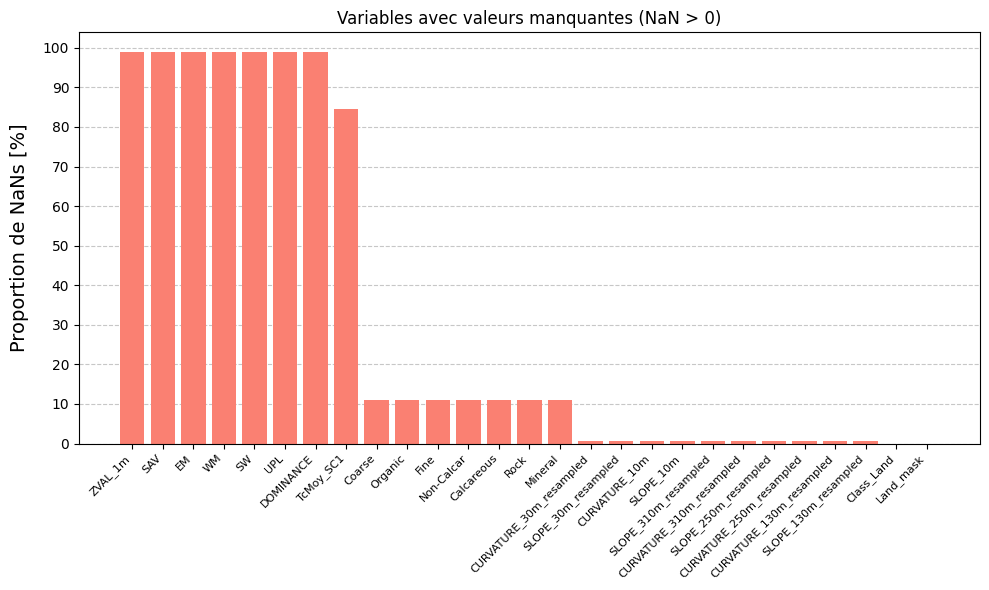

In [30]:
# Quantification des données manquantes
nan_perc = df_features.isna().mean()

# N'inclure que les variables avec au moins une valeur manquante.
nan_perc_filt = nan_perc[nan_perc > 0].sort_values(ascending=False)

# Afficher les résultats dans un graphique.
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    nan_perc_filt.index,
    nan_perc_filt.values * 100,
    color='salmon'
    )
ax.set_title('Variables avec valeurs manquantes (NaN > 0)')
ax.set_ylabel('Proportion de NaNs [%]', fontsize=14, labelpad=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.set_yticks(np.arange(0, 110, 10))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
    label.set_rotation(45)
    label.set_ha('right')

fig.tight_layout()

### 4.2. Suppression des colonnes avec valeurs manquantes excessives

On élimine les colonnes avec un % de données manquantes supérieure à 30%.

On élimine également la variable **TcMin** du jeu de données car celle-ci ne contient que des zéros.

In [31]:
nan_perc = df_features.isna().mean()
cols_to_drop = nan_perc[nan_perc > 0.3].index.tolist()

df_features_clean = df_features.drop(columns=cols_to_drop)

print(
    f"Les {len(cols_to_drop)} colonnes suivantes ont été retirées du jeu "
    f"de données car elles contiennent plus de 30% de valeurs manquantes :\n"
    + "\n".join(f"   - {col} ({nan_perc[col] * 100:0.1f}%)" for
                col in cols_to_drop)
    )

if selected_period == 1:
    cols_to_drop = ['TcMin_SC1']
else:
    cols_to_drop = [f'TcMin_PSC{selected_period}']

df_features_clean = df_features_clean.drop(columns=cols_to_drop)

print("\nLa variable 'TcMin' a également été retirée, car elle ne "
      "contient que des zéro.")

print(f"\nNombre de colonnes : "
      f"{df_features.shape[1]} → {df_features_clean.shape[1]}")

Les 8 colonnes suivantes ont été retirées du jeu de données car elles contiennent plus de 30% de valeurs manquantes :
   - ZVAL_1m (99.0%)
   - SAV (99.0%)
   - EM (99.0%)
   - WM (99.0%)
   - SW (99.0%)
   - UPL (99.0%)
   - DOMINANCE (99.0%)
   - TcMoy_SC1 (84.6%)

La variable 'TcMin' a également été retirée, car elle ne contient que des zéro.

Nombre de colonnes : 46 → 37


### 4.3. Imputation des valeurs manquantes et encodage des variables catégorielles

Pour traiter les valeurs manquantes restantes dans le jeu de données, on
distingue deux approches :

1. Supprimer les lignes contenant des valeurs manquantes (perte d'information)

2. Imputer les valeurs manquantes, c'est-à-dire les remplacer par une valeur estimée

Dans la cellule ci-dessous, nous choisissons d'imputer les valeurs manquantes à l'aide de stratégies adaptées au type de variable. Nous utilisons pour cela la classe `ColumnTransformer`, qui permet d'appliquer sélectivement les bons traitements à chaque groupe de variables.

On distingue deux types de variables :

1. Pour les **variables numériques** : nous utilisons la méthode `SimpleImputer` de scikit-learn avec la stratégie de la moyenne, ce qui permet de remplacer chaque donnée manquante par la moyenne des valeurs observées dans la colonne concernée.

2. Pour les **variables catégorielles** : nous utilisons l'encodeur ordinal
 (`OrdinalEncoder`) de scikit-learn. Cette transformation attribue un code numérique unique à chaque modalité rencontrée dans une colonne catégorielle.<br>Attention : cette méthode n'est généralement adéquate que si l'ordre attribué n'a pas d'importance, ou pour des algorithmes supervisés au sens large. Les éventuelles valeurs manquantes dans les colonnes catégorielles seront considérées comme une nouvelle catégorie inconnue et codées en conséquence.

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

# On définit les colonnes qui sont des variables catégorielles.
cat_vars = [
    'Calcareous', 'Class_Land', 'Coarse', 'Fine',
    'HGM_BL', 'HGM_LOE', 'HGM_LPP', 'HGM_RRB', 'HGM_RRO',
    'Land_mask', 'Mineral', 'Non-Calcar', 'Organic', 'Rock'
    ]

# On définit les colonnes qui sont des variables numériques.
notnum = ((np.isin(df_features_clean.columns, cat_vars)) |
          (df_features_clean.columns == 'CLASSIF'))
num_vars = list(df_features_clean.columns[~notnum])

# Création du ColumnTransformer, où l'on associe des transformateurs
# spécifiques à des colonnes spécifiques.
preprocessor = ColumnTransformer(
    transformers=[
        ('none', 'passthrough', ['CLASSIF']),
        ('num_imputer', SimpleImputer(strategy='mean'), num_vars),
        ('cat_imputer', OrdinalEncoder(), cat_vars),
        ],
    )

# Application de la transformation pour imputer les valeurs manquantes.
df_features_nonan = pd.DataFrame(
    data=preprocessor.fit_transform(df_features_clean),
    columns=['CLASSIF'] + num_vars + cat_vars,
    index=df_features_clean.index
    )


## 5. Exploration des relations entre les variables explicatives

### 5.1 Visualisation des relations entre variables

L'exploration visuelle des relations entre variables permet d'identifier des patterns de séparation entre les classes et de comprendre quelles variables sont les plus discriminantes.

Cela est réalisé à l'aide d'une **matrice de dispersion** (pairplot) qui montre les relations bivariées entre les variables explicatives sélectionnées, colorées par classe de milieu humide.

Étant donné la taille du dataset (> 1 million d'observations), nous sous-échantillonnons stratifié à **1%** pour rendre la génération du graphique réalisable tout en préservant la distribution des classes.

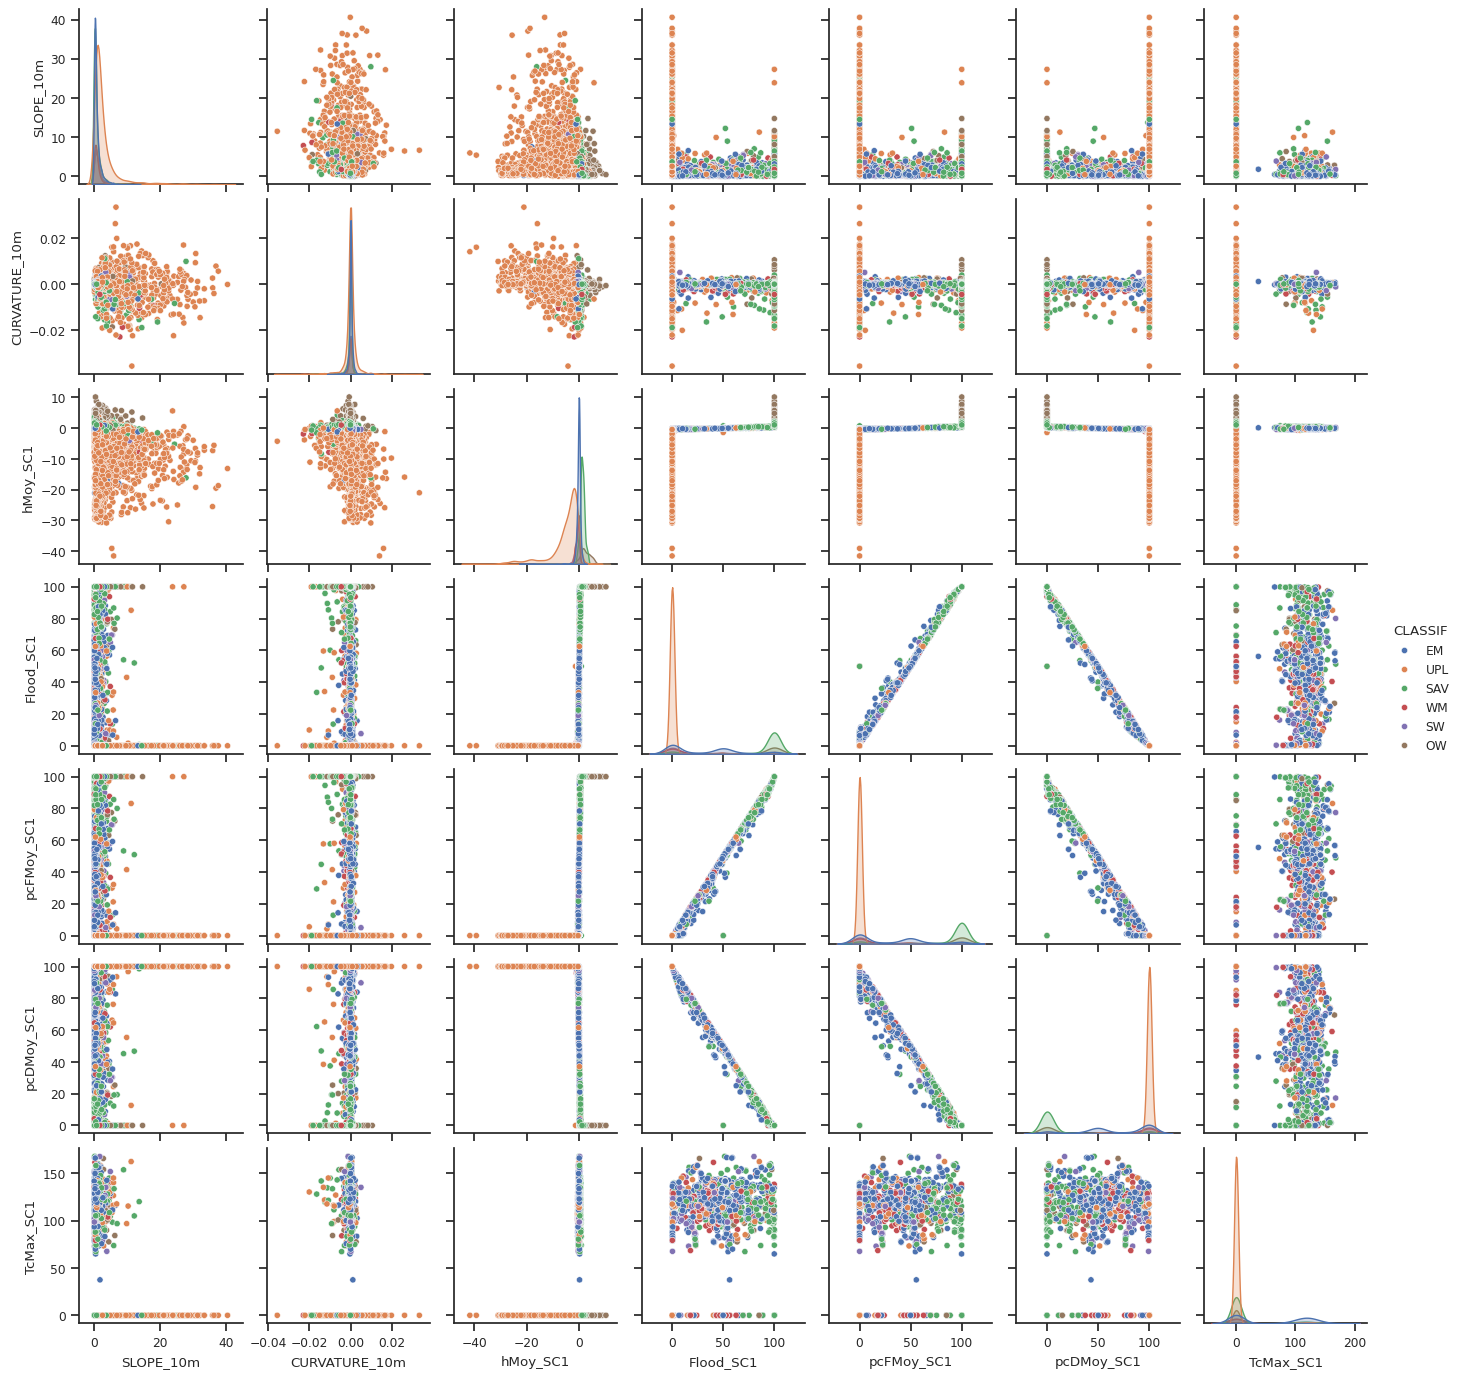

In [33]:
import seaborn as sns
from sklearn.model_selection import train_test_split

# Sélection des variables que l'on veut afficher.
cols = ['SLOPE_10m', 'CURVATURE_10m']
if selected_period == 1:
    cols += ['hMoy_SC1',
             'Flood_SC1',
             'pcFMoy_SC1',
             'pcDMoy_SC1',
             'TcMax_SC1']
else:
    cols += [f'hMoy_PSC{selected_period}',
             f'Flood_PSC{selected_period}',
             f'pcFMoy_PSC{selected_period}',
             f'pcDMoy_PSC{selected_period}',
             f'TcMax_PSC{selected_period}']

# Sous-échantillonnage stratifié à 1% du dataset pour rendre
# le temps de production des graphiques raisonnable en raison du
# grand nombre d'échantillone (> 1 million) dans le jeu de données
# complet.
y_full = df_features_nonan['CLASSIF'].values
X_full = df_features_nonan[cols].values
X_sample, _, y_sample, _ = train_test_split(
    X_full, y_full,
    train_size=0.01,
    stratify=y_full
    )

df_sample = pd.DataFrame(
    data=X_sample,
    columns=cols)
df_sample['CLASSIF'] = y_sample

# Génération du graph 'pairplot'.
sns.set_theme(style="ticks", font_scale=0.8)
ax = sns.pairplot(
    df_sample, hue="CLASSIF",
    height=2, aspect=1.0,
    plot_kws={'s': 20},
    )

### 5.2 Matrice de corrélation des variables numériques

La **matrice de corrélation** révèle les relations linéaires entre toutes les variables explicatives numériques. Cette analyse permet d'identifier la **multicolinéarité** (variables fortement corrélées entre elles) et les variables redondantes qui apportent peu d'information supplémentaire au modèle.

Les valeurs de corrélation varient entre -1 (corrélation négative parfaite) et +1 (corrélation positive parfaite), avec 0 indiquant une absence de relation linéaire. Des corrélations élevées (|r| > 0.8) suggèrent que certaines variables mesurent des phénomènes similaires et pourraient être candidates à l'élimination pour simplifier le modèle.

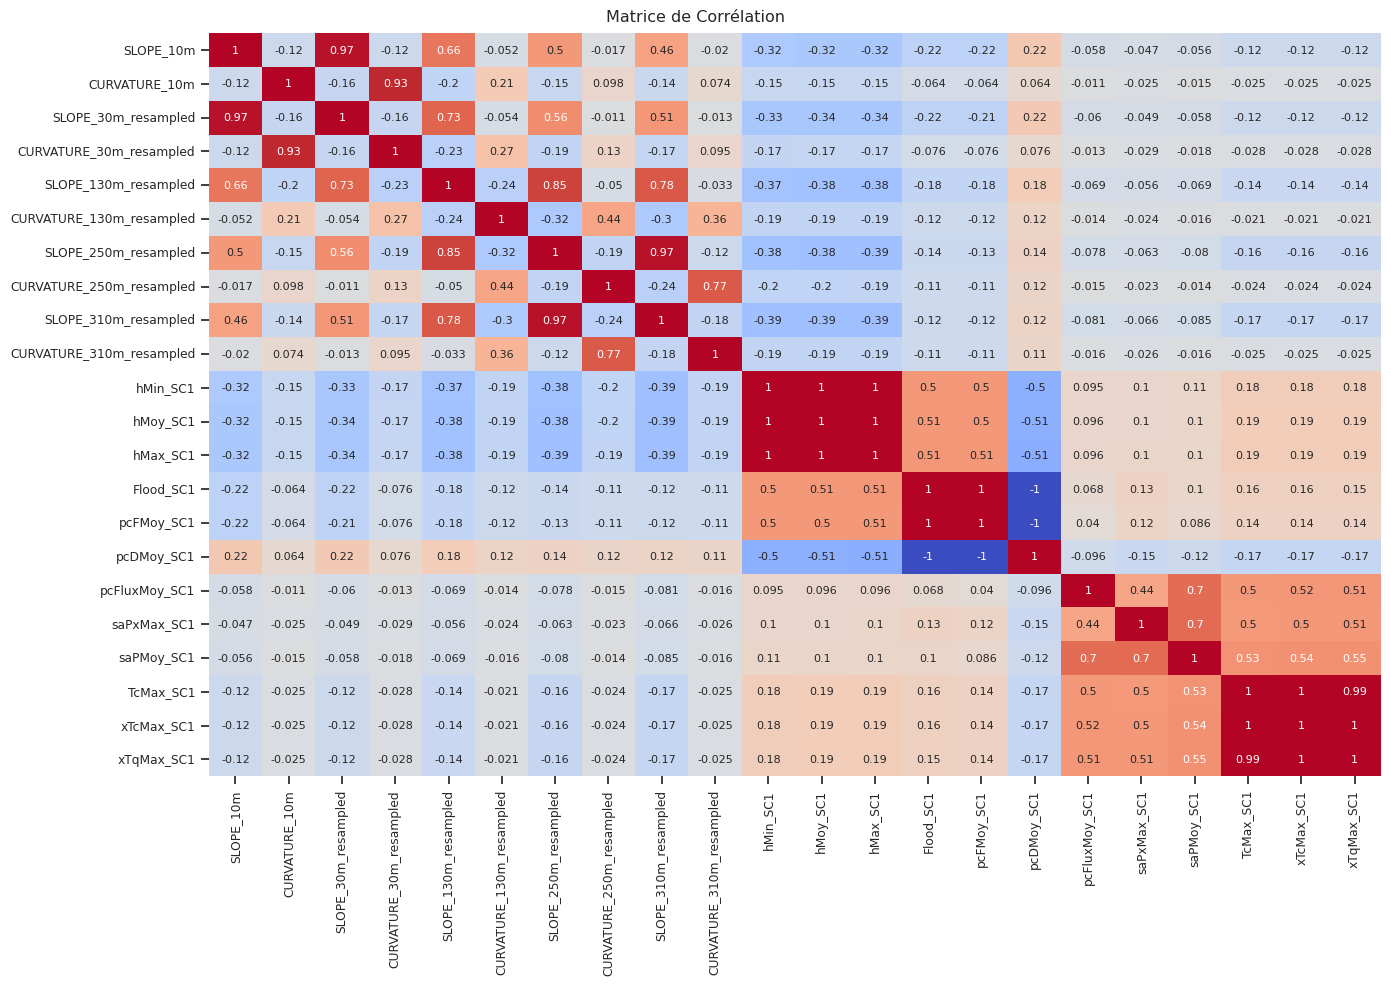

In [34]:
corr_matrix = df_features_nonan[num_vars].corr()

fig, ax = plt.subplots(figsize=(14, 10))
sns.set_theme(style="ticks", font_scale=0.8)
sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm',
    ax=ax, cbar=False, annot_kws={"fontsize": 8})
fig.suptitle('Matrice de Corrélation')
fig.tight_layout()
plt.show()

## 6. Prédiction avec un modèle KNN (K Nearest neighbours)

L'algorithme des k plus proches voisins (KNN) est une méthode de classification non paramétrique basée sur la proximité entre observations. Pour classifier un nouveau point, l'algorithme identifie les k observations les plus proches dans l'espace des variables (selon une distance euclidienne) et lui attribue la classe majoritaire parmi ces voisins. Cette approche est particulièrement adaptée aux problèmes où les classes présentent une structure spatiale claire dans l'espace des variables explicatives.




### 6.1 Préparation des données pour le modèle KNN

Avant d'entraîner le modèle KNN, nous devons effectuer quatre étapes de préparation :

**1. Sélection des variables numériques**

L'algorithme KNN repose sur le calcul de distances euclidiennes. Les variables catégorielles encodées numériquement introduisent un ordre artificiel qui fausse la mesure de similarité. Nous ne conservons donc que les variables numériques.

**2. Définition des variables X (explicatives) et y (cible)**

- Variable cible (y) : la classe de milieu humide à prédire (`CLASSIF`)
- Variables explicatives (X) : l'ensemble des variables numériques prétraitées.

**3. Sous-échantillonnage stratifié à 10%**

L'algorithme KNN stocke l'ensemble du jeu d'entraînement en mémoire et calcule les distances avec toutes les observations à chaque prédiction. Avec plus d'un million de lignes, cela rendrait l'entraînement et la prédiction extrêmement lents. Nous sous-échantillonnons donc à **10% du dataset** (≈100 000 observations), ce qui reste représentatif tout en étant computationnellement réalisable. Le sous-échantillonnage est stratifié pour conserver la proportion des classes.

**4. Division en jeux d'entraînement et de test**

Séparation des données sous-échantillonnées en jeu d'entraînement (70%) et de test (30%) avec stratification pour préserver la distribution des classes.


In [35]:
from sklearn.model_selection import train_test_split

# Définition de X (features) et y (target). On ne sélectionne que les
# variables numérique pour X.
y_full = df_features_nonan['CLASSIF'].values
X_full = df_features_nonan[num_vars].values

# Sous-échantillonnage stratifié à 10% du dataset pour rendre
# l'entraînement et la prédiction réalisables.
X_sample, _, y_sample, _ = train_test_split(
    X_full, y_full,
    train_size=0.1,
    random_state=0,
    stratify=y_full
    )

print(f"Dataset complet : {X_full.shape[0]:_} observations".replace("_", " "))
print(f"Dataset sous-échantillonné : {X_sample.shape[0]:_} observations ({X_sample.shape[0]/X_full.shape[0]*100:.1f}%)\n".replace("_", " "))

# Division des données sous-échantillonnées en jeu d'entraînement (70%) et
# de test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.30,  # 30% pour le test
    random_state=0,
    stratify=y_sample
    )

print(f"Jeu d'entraînement : {X_train.shape[0]:_} observations × {X_train.shape[1]} variables".replace("_", " "))
print(f"Jeu de test : {X_test.shape[0]:_} observations × {X_test.shape[1]} variables".replace("_", " "))

Dataset complet : 1 081 838 observations
Dataset sous-échantillonné : 108 183 observations (10.0%)

Jeu d'entraînement : 75 728 observations × 22 variables
Jeu de test : 32 455 observations × 22 variables


### 6.2 Prédiction et optimisation du nombre de voisins

Le nombre de voisins **k** est l'hyperparamètre clé de KNN : une valeur trop faible rend le modèle sensible au bruit (surapprentissage), tandis qu'une valeur trop élevée sur-lisse les prédictions (sous-apprentissage).

**Normalisation des données**  
KNN repose sur le calcul de distances euclidiennes. Sans normalisation, les variables avec de grandes plages de valeurs domineraient le calcul. Nous utilisons `StandardScaler` pour ramener toutes les variables à la même échelle (moyenne = 0, écart-type = 1), garantissant ainsi que chaque variable contribue équitablement à la mesure de similarité.

**Recherche du k optimal**  
Nous testons différentes valeurs de k (de 3 à 30) et sélectionnons celle qui maximise l'exactitude sur le jeu de test. Le graphique ci-dessous montre que **k=5** donne le meilleur score (78.03%). On observe également qu'au-delà de k=9 voisins, il n'y a aucun gain de performance, les scores décroissant progressivement jusqu'à 77.07% pour k=30.


Prédictions avec 3 voisins... score=77.45%
Prédictions avec 4 voisins... score=77.75%
Prédictions avec 5 voisins... score=78.03%
Prédictions avec 6 voisins... score=77.91%
Prédictions avec 7 voisins... score=78.00%
Prédictions avec 8 voisins... score=77.85%
Prédictions avec 9 voisins... score=77.97%
Prédictions avec 10 voisins... score=77.80%
Prédictions avec 11 voisins... score=77.82%
Prédictions avec 12 voisins... score=77.85%
Prédictions avec 13 voisins... score=77.91%
Prédictions avec 14 voisins... score=77.81%
Prédictions avec 15 voisins... score=77.72%
Prédictions avec 20 voisins... score=77.45%
Prédictions avec 25 voisins... score=77.22%
Prédictions avec 30 voisins... score=77.07%




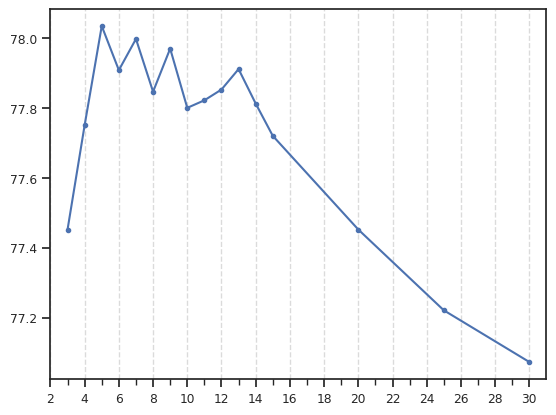

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Normalisation des données.
ss = StandardScaler()
ss.fit(X_train)

# Optimisation du nombre de voisins (n).
n_neighbors = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30]
scores = np.full(len(n_neighbors), np.nan)

for i, n in enumerate(n_neighbors):
    print(f"Prédictions avec {n} voisins... ", end='')

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(ss.transform(X_train), y_train)

    y_pred = knn.predict(ss.transform(X_test))

    scores[i] = accuracy_score(y_test, y_pred, normalize=True)

    print(f'score={scores[i]*100:0.2f}%')

print()

fig, ax = plt.subplots()
line2d, = ax.plot(n_neighbors, scores * 100, marker='.')
ax.set_xticks(np.arange(2, 32, 2))
ax.set_xticks(np.arange(30), minor=True)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.axis(xmin=2, xmax=31)

print()


## 7. Prédiction avec un modèle SVC (Support Vector Classifier)

Le _Support Vector Classifier (SVC)_ est un algorithme populaire dans plusieurs domaines car il ne nécessite pas d'opimiser de nombreux paramètres. Il permet de prendre en compte des relations complexes entre les variables grâce au "kernel trick".

L'objectif est de séparer les classes en traçant une frontière qui laisse le plus d'espace possible entre les groupes. Cette méthode est particulièrement efficace en haute dimension et robuste au surapprentissage.

Comme KNN, SVC nécessite des données numériques (il calcule des distances dans un espace vectoriel), il est donc nécessaire de normaliser les variables. De plus, SVC peut être plus lent à entraîner que Random Forest ou KNN sur de grands datasets. Nous utiliserons donc un sous-échantillon à 1%.

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Préparation du dataset.
y_full = df_features_nonan['CLASSIF'].values
X_full = df_features_nonan[num_vars].values

X_sample, _, y_sample, _ = train_test_split(
    X_full, y_full,
    train_size=0.01,
    random_state=0,
    stratify=y_full
    )

print(f"Dataset complet : {X_full.shape[0]:_} observations".replace("_", " "))
print(f"Dataset sous-échantillonné : {X_sample.shape[0]:_} observations ({X_sample.shape[0]/X_full.shape[0]*100:.1f}%)\n".replace("_", " "))

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.30,
    random_state=0,
    stratify=y_sample
    )

print(f"Jeu d'entraînement : {X_train.shape[0]:_} observations × {X_train.shape[1]} variables".replace("_", " "))
print(f"Jeu de test : {X_test.shape[0]:_} observations × {X_test.shape[1]} variables".replace("_", " "))

# Normalisation des données.
ss = StandardScaler()
ss.fit(X_train)

# Entraînement du modèle.
print("\nEntraînement du modèle SVC en cours...", end='')
svc = SVC(
    kernel="rbf",
    C=1.0, # paramètre de régularisation
    gamma="scale",
    probability=True,   # utile si tu veux SHAP / proba
    random_state=42
    )
svc.fit(ss.transform(X_train), y_train)
print(' OK')

# Prédictions.
y_pred_svc = svc.predict(ss.transform(X_test))

# Évaluation.
score = accuracy_score(y_test, y_pred_svc, normalize=True)

print(f"\nExactitude SVC : {score * 100:.2f}%")
print(classification_report(y_test, y_pred_svc, zero_division=0))

Dataset complet : 1 081 838 observations
Dataset sous-échantillonné : 10 818 observations (1.0%)

Jeu d'entraînement : 7 572 observations × 22 variables
Jeu de test : 3 246 observations × 22 variables

Entraînement du modèle SVC en cours... OK

Exactitude SVC : 73.35%
              precision    recall  f1-score   support

          EM       0.55      0.66      0.60       555
          OW       0.85      0.55      0.66       200
         SAV       0.77      0.79      0.78       624
          SW       0.00      0.00      0.00       195
         UPL       0.78      0.96      0.86      1473
          WM       0.00      0.00      0.00       199

    accuracy                           0.73      3246
   macro avg       0.49      0.49      0.48      3246
weighted avg       0.65      0.73      0.68      3246



## 8. Prédiction avec un modèle Random Forest

Le **Random Forest** est un algorithme d'ensemble qui combine les prédictions de multiples arbres de décision entraînés sur différents sous-échantillons des données. Chaque arbre vote pour une classe, et la classe majoritaire est retenue comme prédiction finale, réduisant ainsi le risque de surapprentissage.

Le workflow reste similaire à celui de KNN (préparation, optimisation, évaluation), mais Random Forest présente deux avantages majeurs : il peut traiter **l'ensemble complet du dataset** (> 1 million d'observations) et il accepte les **variables catégorielles**.

### 8.1 Préparation des données pour le modèle Random Forest

Pour des raisons pédagogiques et afin de maintenir des temps de calcul raisonnables, nous sous-échantillonnons à **10% du dataset** comme nous l'avons fait précédemment avec le modèle KNN. Contrairement à KNN toutefois, nous utilisons maintenant **toutes les variables** : numériques et catégorielles.

Nous normalisons les variables numériques avec `StandardScaler`. Bien que ce ne soit pas strictement nécessaire pour Random Forest (basé sur des arbres de décision), la littérature suggère que cela peut améliorer légèrement la stabilité et les performances du modèle.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Définition de X (features) et y (target). Toutes les variables sont
# gardées pour X.
y_full = df_features_nonan['CLASSIF'].values
X_full = df_features_nonan[num_vars + cat_vars].values

# Sous-échantillonnage stratifié à 10% du dataset pour rendre
# l'entraînement et la prédiction plus rapide dans le cadre du cours.
X_sample, _, y_sample, _ = train_test_split(
    X_full, y_full,
    train_size=0.1,
    random_state=0,
    stratify=y_full
    )

print(f"Dataset complet : {X_full.shape[0]:_} observations".replace("_", " "))
print(f"Dataset sous-échantillonné : {X_sample.shape[0]:_} observations ({X_sample.shape[0]/X_full.shape[0]*100:.1f}%)\n".replace("_", " "))

# Division des données sous-échantillonnées en jeu d'entraînement (70%) et
# de test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.30,  # 30% pour le test
    random_state=0,
    stratify=y_sample
    )

print(f"Jeu d'entraînement : {X_train.shape[0]:_} observations × {X_train.shape[1]} variables".replace("_", " "))
print(f"Jeu de test : {X_test.shape[0]:_} observations × {X_test.shape[1]} variables".replace("_", " "))

# Normalisation des variables.
scaler = ColumnTransformer(
    transformers=[
        ('num_imputer', StandardScaler(), num_vars),
        ],
    remainder='passthrough'
    )

X_train_std = scaler.fit_transform(
    pd.DataFrame(X_train, columns=num_vars + cat_vars)
    )
X_test_std = scaler.transform(
    pd.DataFrame(X_test, columns=num_vars + cat_vars)
    )


Dataset complet : 1 081 838 observations
Dataset sous-échantillonné : 108 183 observations (10.0%)

Jeu d'entraînement : 75 728 observations × 36 variables
Jeu de test : 32 455 observations × 36 variables


### 8.2. Prédiction et optimisation du nombre d'estimateurs

Le paramètre **n_estimators** contrôle le nombre d'arbres dans la forêt : plus il est élevé, plus le modèle est stable, mais plus le temps de calcul est long. Nous testons différentes valeurs pour identifier le meilleur compromis.

Random Forest possède plusieurs autres hyperparamètres importants (`max_depth`, `min_samples_split`, `max_features`). Des outils comme **GridSearchCV** et **RandomizedSearchCV** permettent d'optimiser plusieurs hyperparamètres simultanément. Ces techniques seront couvertes dans le cours suivant.

Prédictions avec 5 estimateurs... score=83.05%
Prédictions avec 25 estimateurs... score=85.06%
Prédictions avec 50 estimateurs... score=85.47%
Prédictions avec 75 estimateurs... score=85.60%




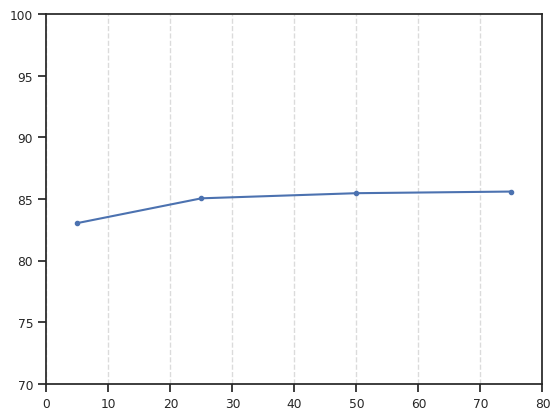

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

n_estimators = [5, 25, 50, 75]
scores = np.full(len(n_estimators), np.nan)

for i, n in enumerate(n_estimators):
    print(f"Prédictions avec {n} estimateurs... ", end='')

    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train_std, y_train)

    y_pred = clf.predict(X_test_std)

    scores[i] = accuracy_score(y_test, y_pred, normalize = True)

    print(f'score={scores[i]*100:0.2f}%')

print()

fig, ax = plt.subplots()
line2d, = ax.plot(n_estimators, scores * 100, marker='.')
ax.set_xticks(np.arange(0, 350, 5))
ax.set_xticks(np.arange(0, 350, 10))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.axis(ymin=70, ymax=100, xmin=0, xmax=80)

print()

### 8.3. Importance des variables

Un avantage majeur de Random Forest est sa capacité à quantifier l'**importance des variables** (feature importance). Cette métrique indique la contribution de chaque variable aux prédictions du modèle, calculée en mesurant la réduction moyenne de l'impureté (Gini) apportée par chaque variable à travers tous les arbres de la forêt.

L'analyse de l'importance des variables permet d'identifier les variables les plus discriminantes pour la classification, de simplifier le modèle en éliminant les variables peu informatives, et d'améliorer l'interprétabilité des résultats. Cette information est particulièrement utile pour comprendre quels facteurs (topographie, hydrologie, etc.) sont les plus déterminants pour caractériser les différentes classes de milieux humides.

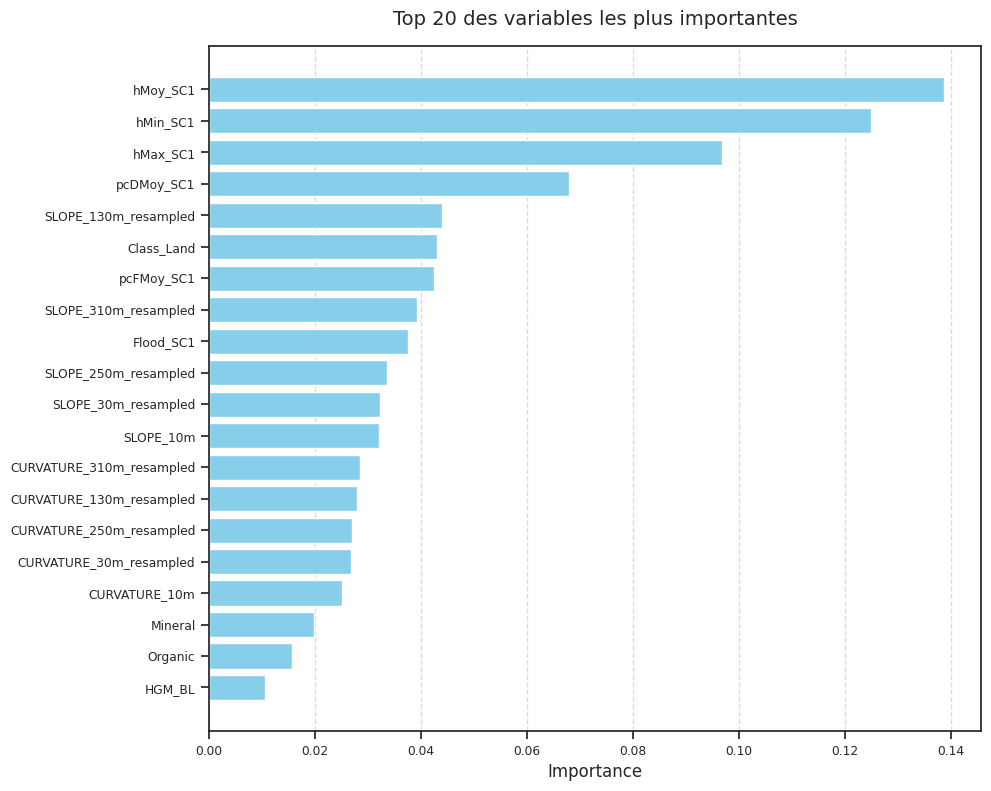

In [40]:
# Extraction de l'importance des variables.
importances = clf.feature_importances_
feature_names = num_vars + cat_vars

importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
    }).sort_values('Importance', ascending=False)

# Visualisation graphique
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20  # Nombre de variables à afficher

importance_df_top = importance_df.head(top_n)
ax.barh(range(top_n), importance_df_top['Importance'], color='skyblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(importance_df_top['Variable'])
ax.invert_yaxis()  # Variable la plus importante en haut
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top {top_n} des variables les plus importantes', fontsize=14, pad=15)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

fig.tight_layout()
plt.show()

### 8.4 Matrice de confusion

La **matrice de confusion** visualise les performances du modèle classe par classe. Chaque ligne représente les observations d'une classe réelle, et chaque colonne les prédictions du modèle. Les valeurs sur la **diagonale** (en foncé) représentent les prédictions correctes, tandis que les valeurs hors diagonale indiquent les erreurs de classification.

Cette visualisation est particulièrement utile pour identifier :
- Les classes bien prédites (valeurs élevées sur la diagonale)
- Les confusions fréquentes entre certaines classes (valeurs élevées hors diagonale)
- Les biais liés au déséquilibre des classes

La matrice normalisée (en pourcentages) permet de comparer les performances entre classes indépendamment de leur nombre d'observations.

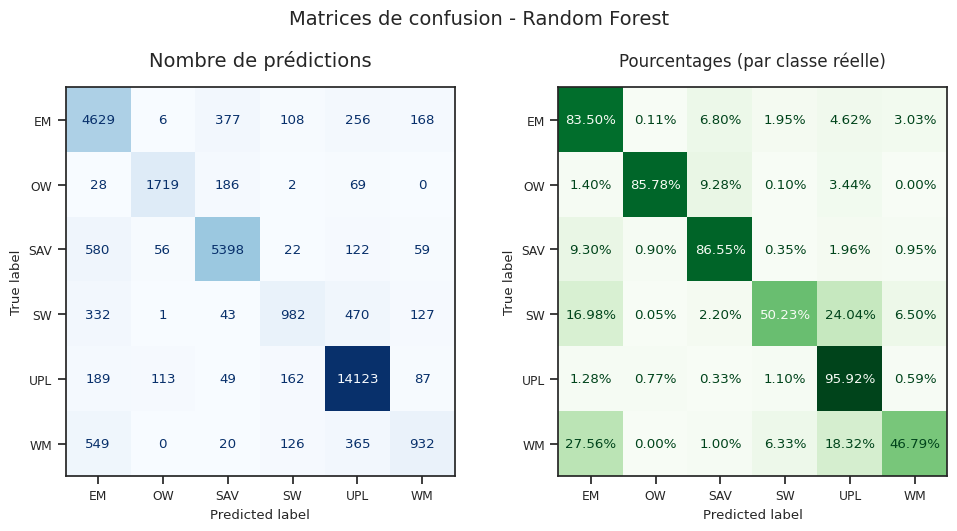

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Création des deux matrices.
cm_counts = confusion_matrix(y_test, y_pred)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Visualisation côte à côte.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Matrice avec les comptes.
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_counts, display_labels=clf.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)

axes[0].set_title('Nombre de prédictions', fontsize=14, pad=15)

# Matrice normalisée.
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=clf.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='.2%', colorbar=False)

axes[1].set_title('Pourcentages (par classe réelle)', fontsize=12, pad=15)

fig.suptitle('Matrices de confusion - Random Forest', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 8.5 Interprétabilité avec les valeurs SHAP

Les **valeurs de Shapley (SHAP)** quantifient la contribution de chaque variable à la prédiction d'une classe spécifique. Contrairement à l'importance globale des variables (section 8.3), SHAP explique comment et dans quelle direction chaque variable influence les prédictions.

Puisque cette opération est très longue, on va sous-échantillonné à 1% et
on ne gardera que les 6 variables les plus importantes (de la section 8.3).

Dataset complet : 1 081 838 observations
Dataset sous-échantillonné : 10 818 observations (1.0%)

Calcul des valeurs SHAP en cours...



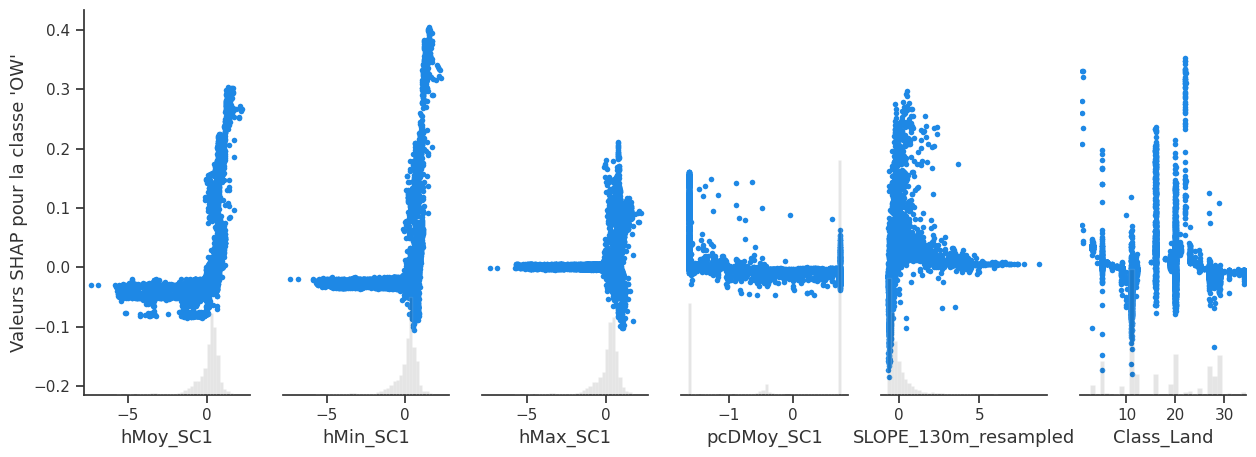

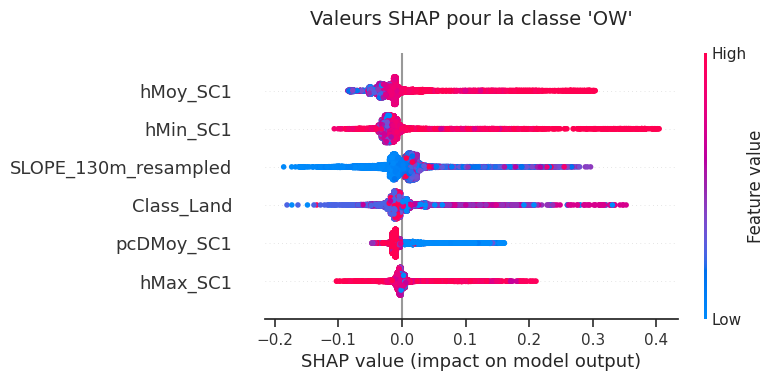

In [42]:
import shap

SELECTED_CLASS = 'OW'
# Classes disponibles: 'BOG', 'FEN', 'MAR', 'OW', 'SAV', 'UPL'

# Préparation du dataset.
y_full = df_features_nonan['CLASSIF'].values
X_full = df_features_nonan[num_vars + cat_vars].values

X_sample, _, y_sample, _ = train_test_split(
    X_full, y_full,
    train_size=0.01,
    random_state=0,
    stratify=y_full
    )

print(f"Dataset complet : {X_full.shape[0]:_} observations".replace("_", " "))
print(f"Dataset sous-échantillonné : {X_sample.shape[0]:_} observations ({X_sample.shape[0]/X_full.shape[0]*100:.1f}%)\n".replace("_", " "))

# Normalisation des variables.
scaler = ColumnTransformer(
    transformers=[
        ('num_imputer', StandardScaler(), num_vars),
        ],
    remainder='passthrough'
    )

X_sample_std = scaler.fit_transform(
    pd.DataFrame(X_sample, columns=num_vars + cat_vars)
    )
X_sample_std = pd.DataFrame(X_sample_std, columns=num_vars + cat_vars)

# Sélection des 6 variables les plus importantes.
X_sample_std = X_sample_std.loc[:, importance_df.Variable[:6]]


# Création de l'explainer et calcul des valeurs SHAP.
print("Calcul des valeurs SHAP en cours...")

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_sample_std, y_sample)

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_sample_std)

# Extraction des valeurs SHAP pour la classe sélectionnée.
class_idx = list(clf.classes_).index(SELECTED_CLASS)
shap_values_class = shap_values[:, :, class_idx]

print()

shap.plots.scatter(
    shap_values_class,
    ylabel=f"Valeurs SHAP pour la classe '{SELECTED_CLASS}'"
    )
plt.title(f"Valeurs SHAP pour la classe '{SELECTED_CLASS}'",
          fontsize=14, pad=20)

fig = plt.gcf()
fig.tight_layout()

print('\n\n')

shap.plots.beeswarm(shap_values_class,
                    max_display=15,
                    show=False)
plt.title(f"Valeurs SHAP pour la classe '{SELECTED_CLASS}'",
          fontsize=14, pad=20)

fig = plt.gcf()
fig.tight_layout()
plt.show()